In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import Stepwise, sklearn_selected, sklearn_selection_path
from l0bnb import fit_path

### 6.5.1 Subset Selection Methods

In [2]:
Hitters = load_data('Hitters')
np.isnan(Hitters['Salary']).sum()

59

In [3]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

Forward Selection

In [4]:
def nCp(sigma2, estimator, X, Y):
  "Negative Cp statistic"
  n, p = X.shape
  Yhat = estimator.predict(X)
  RSS = np.sum((Y - Yhat)**2)
  return -(RSS + 2 * p * sigma2) / n

design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y = np.array(Hitters['Salary'])
X = design.transform(Hitters)
sigma2 = OLS(Y,X).fit().scale

neg_Cp = partial(nCp, sigma2)

strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(Hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [5]:
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

full_path.fit(Hitters, Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

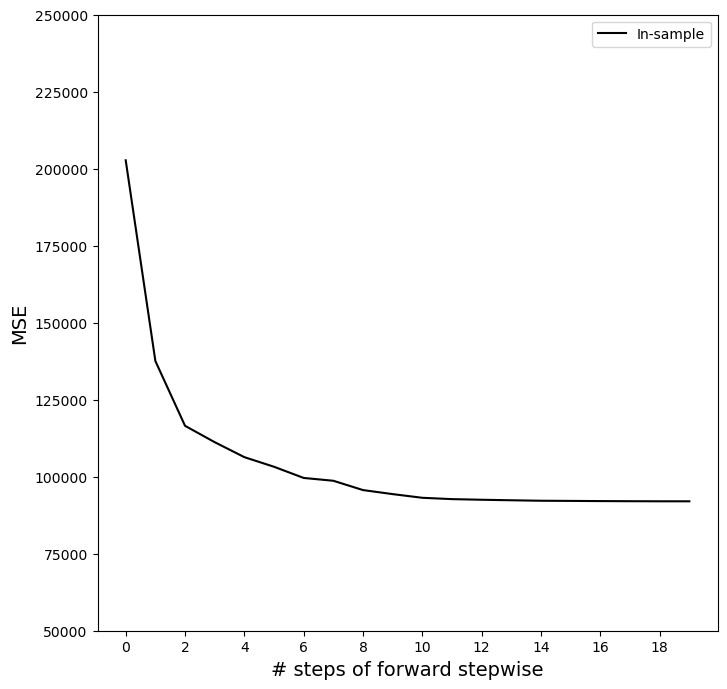

In [11]:
mse_fig, ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:,None])**2).mean(0)
n_steps = insample_mse.shape[0]

ax.plot(np.arange(n_steps), insample_mse, 'k', label='In-sample')
ax.set_ylabel('MSE',fontsize=14)
ax.set_xlabel('# steps of forward stepwise',fontsize=14)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000,250000])

In [8]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, Hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

In [9]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
  errors = (Yhat_cv[test_idx] - Y[test_idx,None])**2
  cv_mse.append(errors.mean(0))
  
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

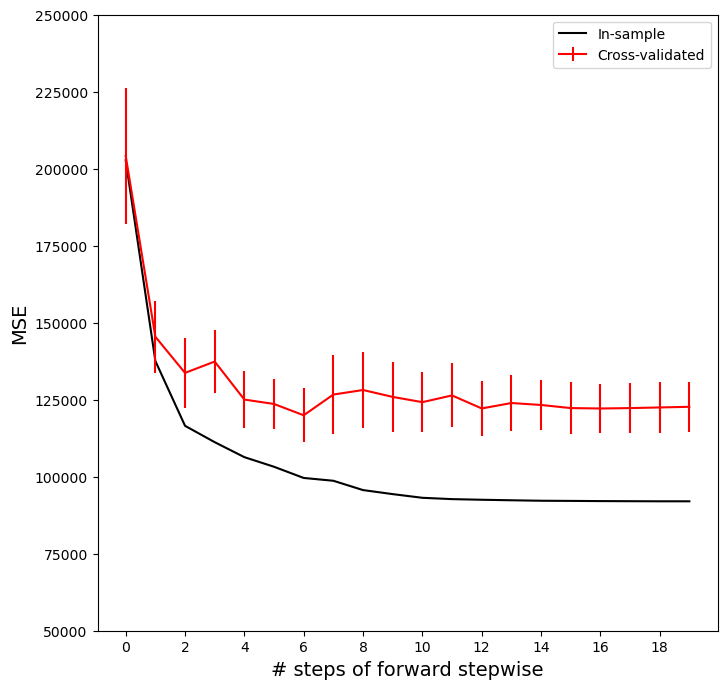

In [12]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1) / np.sqrt(K), label='Cross-validated', c='r')
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

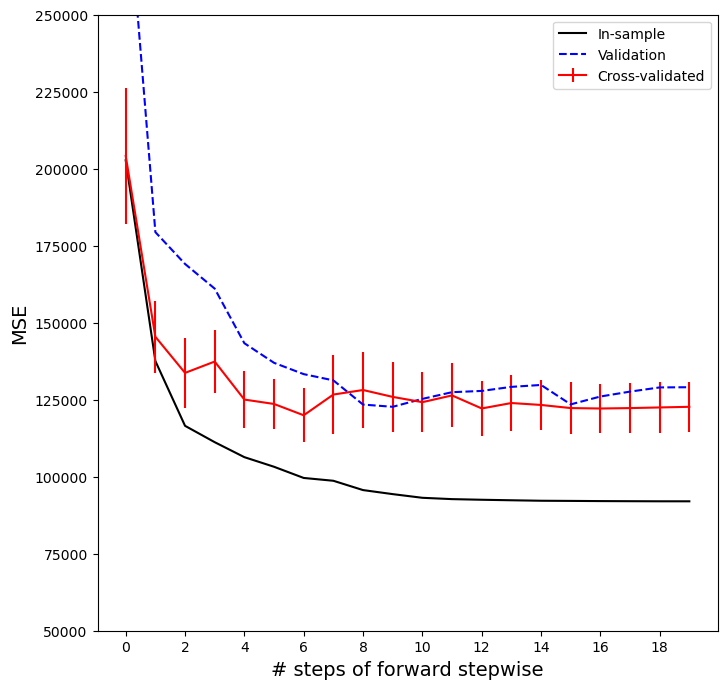

In [13]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_idx, test_idx in validation.split(Y):
  full_path.fit(Hitters.iloc[train_idx], Y[train_idx])
  Yhat_val = full_path.predict(Hitters.iloc[test_idx])
  errors = (Yhat_val - Y[test_idx,None])**2
  validation_mse = errors.mean(0)

ax.plot(np.arange(n_steps), validation_mse, 'b--', label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

Best Subset Selection


In [14]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

path = fit_path(X, Y, max_nonzeros=X.shape[1])

path[3]

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.011416248027450197,
 'M': 0.5829861733382011,
 'Time_exceeded': False}

### 6.5.2 Ridge Regression and the Lasso

Ridge Regression

In [17]:
import warnings
from sklearn.exceptions import ConvergenceWarning

Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=UserWarning)
  warnings.simplefilter("ignore", category=ConvergenceWarning)
    
  soln_array = skl.ElasticNet.path(Xs, Y, l1_ratio=0., alphas=lambdas)[1]

soln_array.shape

(19, 100)

In [18]:
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


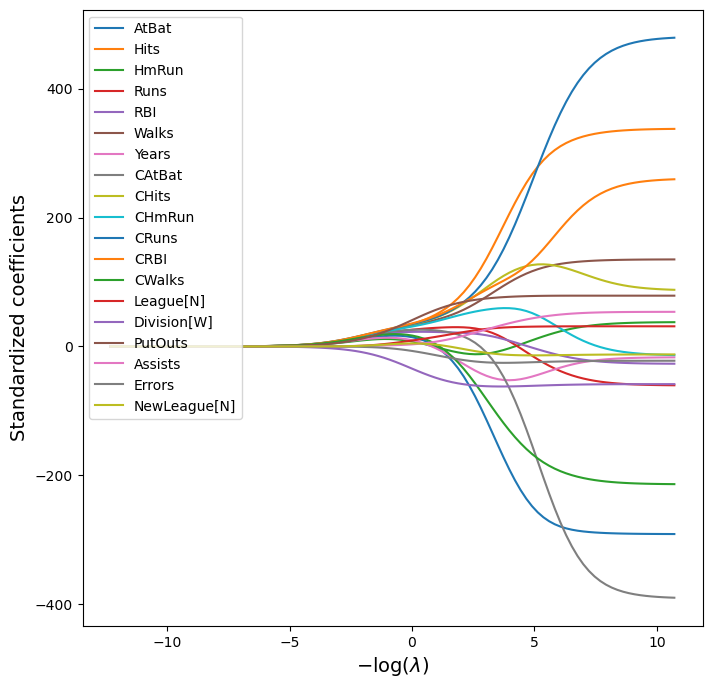

In [22]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=14)
ax.set_ylabel('Standardized coefficients', fontsize=14)
ax.legend(loc='upper left')


In [23]:
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [24]:
np.linalg.norm(beta_hat)

24.170617201443783

In [25]:
beta_hat = soln_path.loc[soln_path.index[59]]
lambdas[59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.4237101772572)

In [ ]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)
    
  ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
  pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
  pipe.fit(X, Y)

np.linalg.norm(ridge.coef_)

160.42371017725904

Estimating Test Error of Ridge Regression


In [32]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)
    
  validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
  ridge.alpha = 0.01
  results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation)
  
-results['test_score']

array([134214.00419204])

In [34]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)

  ridge.alpha = 1e10
  results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation)
  
-results['test_score']

array([231788.32155285])

In [37]:
param_grid = {'ridge__alpha': lambdas}
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)

  grid = skm.GridSearchCV(pipe, param_grid, cv=validation, scoring='neg_mean_squared_error')
  grid.fit(X, Y)
  grid.best_params_['ridge__alpha']

grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [38]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)

  grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
  grid.fit(X, Y)
  grid.best_params_['ridge__alpha']

grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

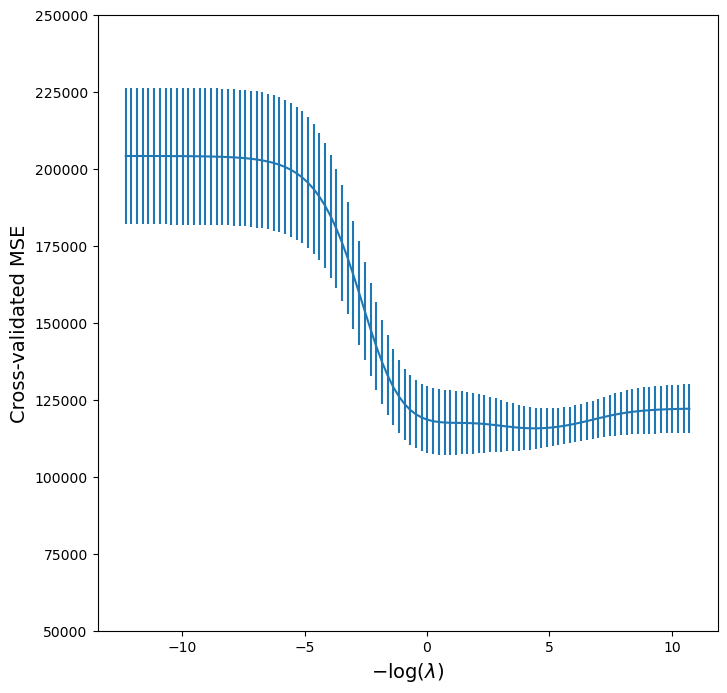

In [39]:
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), -grid.cv_results_['mean_test_score'], yerr=grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylim([50000,250000])
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=14)
ax.set_ylabel('Cross-validated MSE', fontsize=14)

Text(0, 0.5, 'Cross-validated $R^2$')

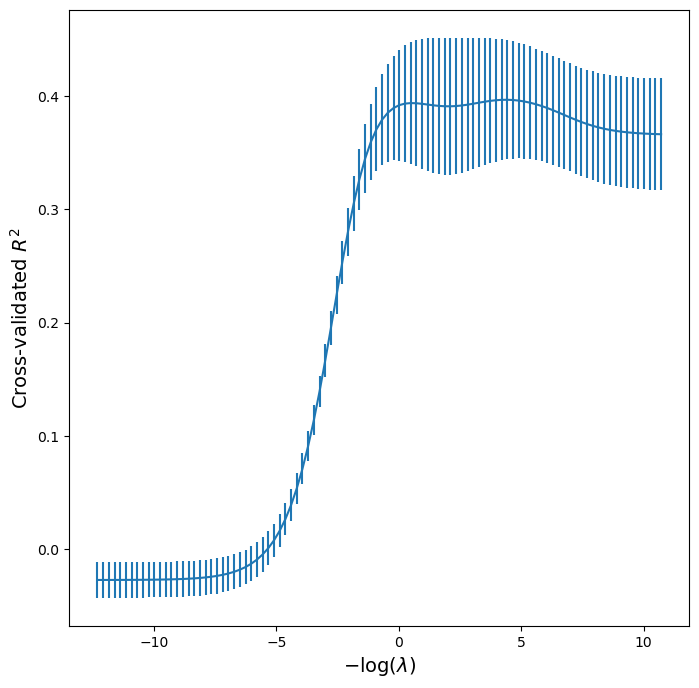

In [44]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)
  
  grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
  grid_r2.fit(X, Y)

r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), grid_r2.cv_results_['mean_test_score'], yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=14)
ax.set_ylabel('Cross-validated $R^2$', fontsize=14)

Fast Cross-Validation for Solution Paths

Text(0, 0.5, 'Cross-validated MSE')

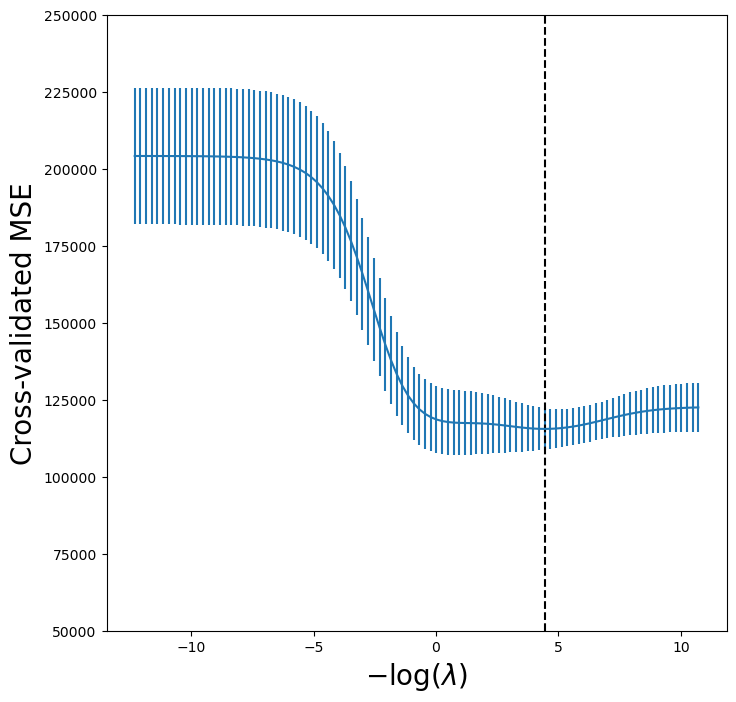

In [50]:
with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)
  warnings.simplefilter("ignore", category=UserWarning)

  ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold)
  pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
  pipeCV.fit(X, Y)

tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), tuned_ridge.mse_path_.mean(1), yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [51]:
np.min(tuned_ridge.mse_path_.mean(1))

115526.70630987943

In [52]:
tuned_ridge.coef_

array([-222.80877051,  238.77246614,    3.21103754,   -2.93050845,
          3.64888723,  108.90953869,  -50.81896152, -105.15731984,
        122.00714801,   57.1859509 ,  210.35170348,  118.05683748,
       -150.21959435,   30.36634231,  -61.62459095,   77.73832472,
         40.07350744,  -25.02151514,  -13.68429544])

Evaluating Test Error of Cross-Validated Ridge

In [ ]:
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])

with warnings.catch_warnings():
  warnings.simplefilter("ignore", category=ConvergenceWarning)
  warnings.simplefilter("ignore", category=UserWarning)
  results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid, scoring='neg_mean_squared_error')
-results['test_score']

array([-132393.84003227])

The Lasso

In [57]:
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

Text(0, 0.5, 'Standardized coefficiients')

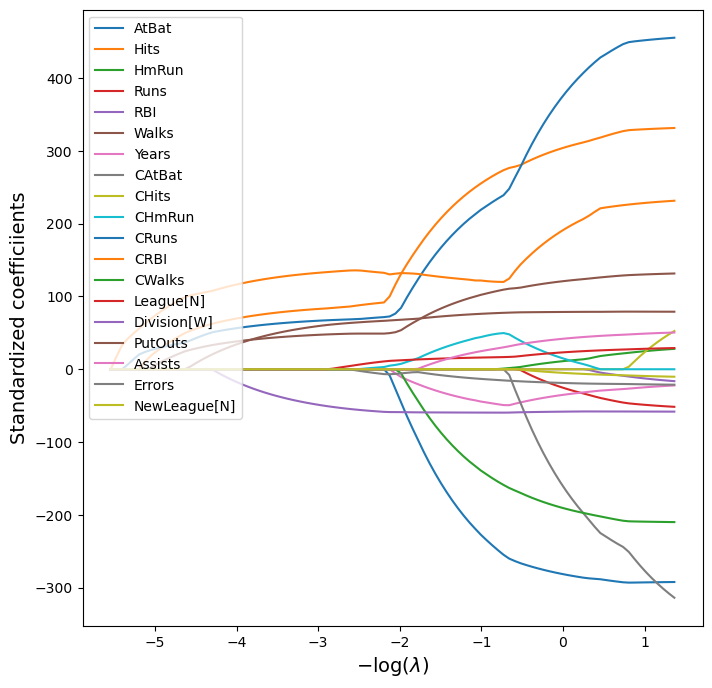

In [61]:
lambdas , soln_array = skl.Lasso.path(Xs, Y, l1_ratio=1, n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))

path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=14)
ax.set_ylabel('Standardized coefficiients', fontsize=14)

In [62]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253634

Text(0, 0.5, 'Cross-validated MSE')

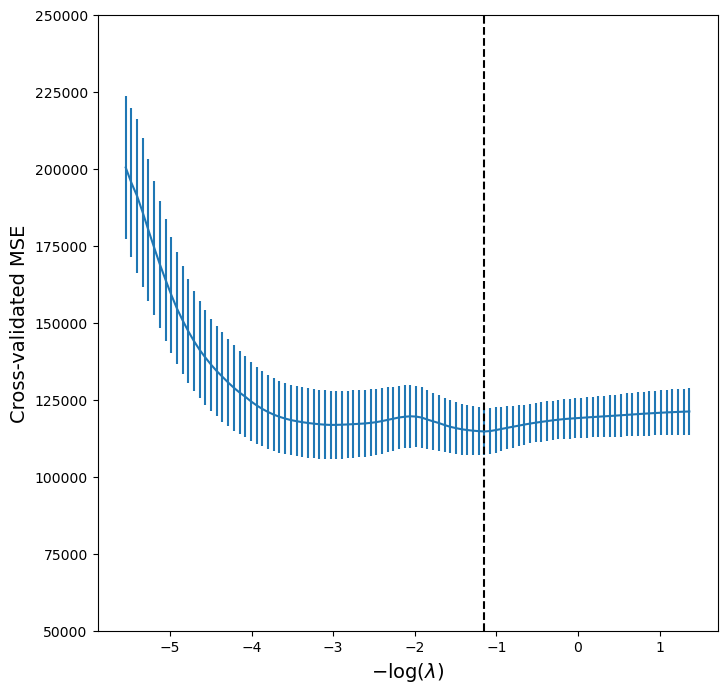

In [64]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=14)
ax.set_ylabel('Cross-validated MSE', fontsize=14)

In [65]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

### 6.5.3 PCR and PLS Regression


Principal Components Regression

In [66]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), ('linreg', linreg)]) 
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [67]:
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(X, Y)
pipe.named_steps['linreg'].coef_

array([106.36859204,  21.60350456])

(50000.0, 250000.0)

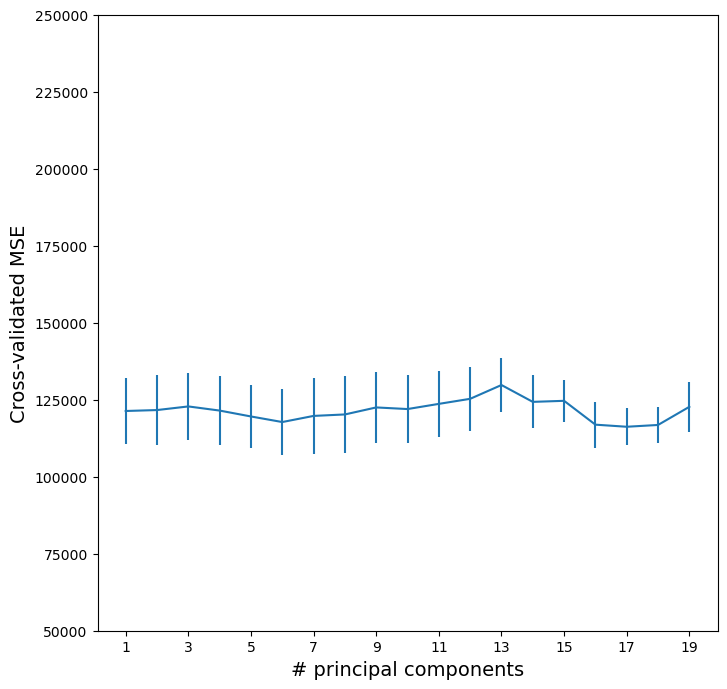

In [70]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=14)
ax.set_xlabel('# principal components', fontsize=14)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])

In [71]:
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg, Xn, Y, cv=kfold, scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

204139.30692994667

In [72]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

Partial Least Squares

In [76]:
pls = PLSRegression(n_components=2,
scale=True)
pls.fit(X, Y)

PLSRegression()

In [79]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls, param_grid, cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

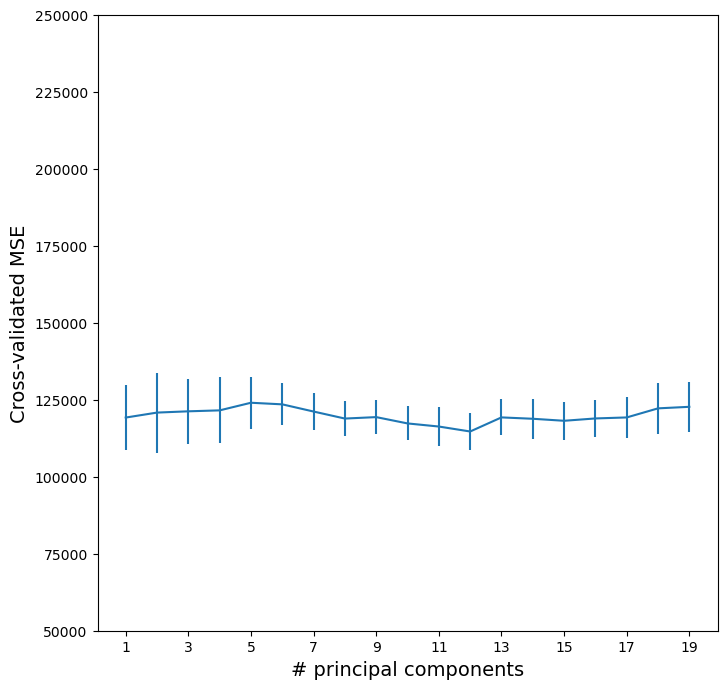

In [80]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross-validated MSE', fontsize=14)
ax.set_xlabel('# principal components', fontsize=14)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])